### Simple Reverse Problem Multihead Latent Attention with positioning (RoPE)

In [1]:
import os
import sys
# Move up one directory
os.chdir("..")
path_models_lib = os.path.join(os.getcwd(), "models")
assert os.path.isdir(path_models_lib), "No folder models"
# Add the parent directory to sys.path
sys.path.append(path_models_lib)

In [3]:
import os
import math
from dataclasses import dataclass
from typing import Tuple, Optional, Literal

import torch
from torch import nn
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

from einops import rearrange
import torch.optim as optim
import torch.utils.data as data
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

## tqdm for loading bars
# from tqdm import tqdm
from tqdm.notebook import tqdm


plt.set_cmap('cividis')
%matplotlib inline
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms


from models.MLA_Rope.MLA_RoPE import ModelArgs, Transformer


In [8]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "C:/Users/Miguel/Documents/Malky/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "C:/Users/Miguel/Documents/Malky/research/saved_models/mla_deepSeek_reverse"


# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 42


Device: cuda:0


In [9]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    # 
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            # ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            # ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [67]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [68]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, args, **kwargs):
        """
        Inputs:
           
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
         # Save hyperparameters to the checkpoint
        self.save_hyperparameters()

        dropout_out = kwargs.get("dropout_out", 0.1)
        self.warmup = kwargs.get('warmup', 50)
        self.max_iters = kwargs.get('max_iters', 50)
        self.lr = kwargs.get("lr", 1e-6 )

        self.vocab_size = args.vocab_size
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.RMSNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_out),
            nn.Linear(args.dim, args.vocab_size)
        )
    
    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps
    
    def configure_optimizers(self):

        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.warmup ,
                                             max_iters=self.max_iters)
         

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "interval": "step"  # Adjust learning rate per step
            }
        }
       
       
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [69]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
       
        inp_data, labels = batch
        inp_data = nn.functional.one_hot(inp_data, num_classes=self.vocab_size).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, mask=None, start_pos=0) 

        loss = nn.functional.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss, prog_bar=True)
        self.log(f"{mode}_acc", acc, prog_bar=True)


        return loss, acc


    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
  
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

Data

In [10]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [11]:
batch_size = 128
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=batch_size)
test_loader  = data.DataLoader(dataset(10000), batch_size=batch_size)

In [12]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([2, 7, 6, 4, 6, 5, 0, 4, 0, 3, 8, 4, 0, 4, 1, 2])
Labels:     tensor([2, 1, 4, 0, 4, 8, 3, 0, 4, 0, 5, 6, 4, 6, 7, 2])


In [ ]:
def train_reverse(args, **kwargs):

    max_epochs = kwargs.get("max_epochs", 10)
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"), 
                   EarlyStopping(monitor='val_acc', patience=20, mode="max")],
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        # logger=TensorBoardLogger(save_dir= os.path.join(CHECKPOINT_PATH ,"logs")),
        devices=1,
        max_epochs=max_epochs,
        gradient_clip_val=5)
    
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:

       
        model = ReversePredictor(args,  **kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [96]:
args = ModelArgs()
args.input_dim = train_loader.dataset.num_categories
args.vocab_size = train_loader.dataset.num_categories
args.max_batch_size = batch_size

args.dim = 32
args.inter_dim =  2 * args.dim
args.n_heads = 1
args.n_layers = 1

args.q_lora_rank = 16
args.kv_lora_rank = 16
args.qk_nope_head_dim  = 4
args.qk_rope_head_dim = 6
args.v_head_dim = 32
args.dropout = 0.1


train = {
    "dropout_out":0.2,
    "warmup" : 200,
    "max_iters":200*len(train_loader),
    "lr": 3e-4,
    "max_epochs": 200
  
    }

reverse_model, reverse_result = train_reverse(args=args, **train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | transformer | Transformer | 9.8 K  | train
1 | output_net  | Sequential  | 1.4 K  | train
----------------------------------------------------
11.3 K    Trainable params
0         Non-trainable params
11.3 K    Total params
0.045     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Miguel\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [98]:
# %load_ext tensorboard
# %tensorboard --logdir os.path.join(CHECKPOINT_PATH, "logs/lightning_logs/version_0")

In [99]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  27.40%
Test accuracy: 27.31%


In [100]:
data_input, labels = next(iter(val_loader))
inp_data = nn.functional.one_hot(data_input, num_classes=train_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data, mask=None, start_pos=0)

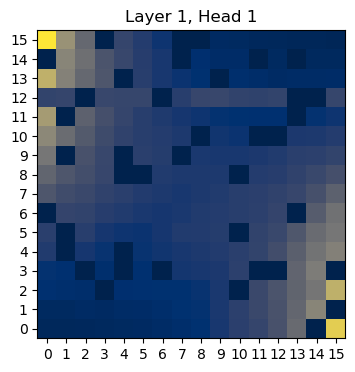

In [101]:
attention_maps[0].shape
plot_attention_maps(data_input, attention_maps, idx=0)

Load model torch lightning

In [4]:
CHECKPOINT_PATH_FILE =  "C:\\Users\\Miguel\\Documents\\Malky\\research\\saved_models\\mla_deepSeek_reverse\\ReverseTask\\lightning_logs\\version_7\\checkpoints\\epoch=9-step=3900.ckpt"

In [5]:
CHECKPOINT_PATH_FILE

'C:\\Users\\Miguel\\Documents\\Malky\\research\\saved_models\\mla_deepSeek_reverse\\ReverseTask\\lightning_logs\\version_7\\checkpoints\\epoch=9-step=3900.ckpt'

In [4]:
from models.MLA_Rope.MLA_RoPE_inference import ModelArgs, Transformer

In [ ]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, args, **kwargs):
        """
        Inputs:
           
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
        """
        super().__init__()
         # Save hyperparameters to the checkpoint
        self.save_hyperparameters()

        self.warmup = kwargs.get('warmup', 50)
        self.max_iters = kwargs.get('max_iters', 50)
        self.lr = kwargs.get("lr", 1e-6 )

        self.vocab_size = args.vocab_size
        dropout_out = kwargs.get("dropout_out", 0.1)
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.RMSNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_out),
            nn.Linear(args.dim, args.vocab_size)
        )
    
    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps

In [14]:
# Load the model from the checkpoint
model = TransformerPredictor.load_from_checkpoint(CHECKPOINT_PATH_FILE)

In [15]:
print(model.state_dict)

<bound method Module.state_dict of TransformerPredictor(
  (transformer): Transformer(
    (embed): Linear(in_features=10, out_features=32, bias=True)
    (layers): ModuleList(
      (0): Block(
        (attn): MLA(
          (wq_a): Linear(in_features=32, out_features=16, bias=True)
          (q_norm): RMSNorm((16,), eps=None, elementwise_affine=True)
          (wq_b): Linear(in_features=16, out_features=10, bias=True)
          (wkv_a): Linear(in_features=32, out_features=22, bias=True)
          (kv_norm): RMSNorm((16,), eps=None, elementwise_affine=True)
          (wkv_b): Linear(in_features=16, out_features=36, bias=True)
          (wo): Linear(in_features=32, out_features=32, bias=True)
        )
        (ffn): MLP(
          (w1): Linear(in_features=32, out_features=64, bias=True)
          (w2): Linear(in_features=64, out_features=32, bias=True)
          (w3): Linear(in_features=32, out_features=64, bias=True)
        )
        (attn_norm): RMSNorm((32,), eps=None, elementwise

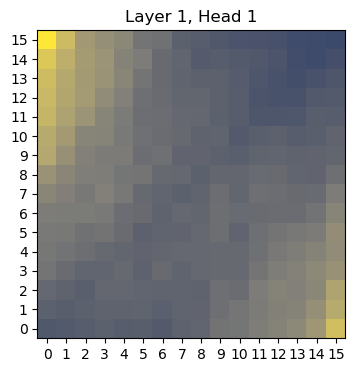

In [25]:
data_input, labels = next(iter(val_loader))
inp_data = nn.functional.one_hot(data_input, num_classes=train_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data, mask=None, start_pos=0)


attention_maps[0].shape
plot_attention_maps(data_input, attention_maps, idx=0)

set model to evaluate

In [18]:
model.eval()

TransformerPredictor(
  (transformer): Transformer(
    (embed): Linear(in_features=10, out_features=32, bias=True)
    (layers): ModuleList(
      (0): Block(
        (attn): MLA(
          (wq_a): Linear(in_features=32, out_features=16, bias=True)
          (q_norm): RMSNorm((16,), eps=None, elementwise_affine=True)
          (wq_b): Linear(in_features=16, out_features=10, bias=True)
          (wkv_a): Linear(in_features=32, out_features=22, bias=True)
          (kv_norm): RMSNorm((16,), eps=None, elementwise_affine=True)
          (wkv_b): Linear(in_features=16, out_features=36, bias=True)
          (wo): Linear(in_features=32, out_features=32, bias=True)
        )
        (ffn): MLP(
          (w1): Linear(in_features=32, out_features=64, bias=True)
          (w2): Linear(in_features=64, out_features=32, bias=True)
          (w3): Linear(in_features=32, out_features=64, bias=True)
        )
        (attn_norm): RMSNorm((32,), eps=None, elementwise_affine=True)
        (ffn_norm): R

In [20]:
with torch.no_grad(): 
    output = model(inp_data, mask=None, start_pos=0)

In [28]:
acc = (output.argmax(dim=-1).detach().cpu() == labels).float().mean()

In [31]:

print("Model Output:", acc)

Model Output: tensor(0.3110)


In [33]:
labels.device

device(type='cpu')

Load with simple torch

In [13]:
import torch
from models.MLA_RoPE_inference import Transformer
from models.MLA_RoPE_inference import ModelArgs

CHECKPOINT_PATH_FILE =  "C:\\Users\\Miguel\\Documents\\Malky\\research\\saved_models\\mla_deepSeek_reverse\\ReverseTask\\lightning_logs\\version_7\\checkpoints\\epoch=9-step=3900.ckpt"

In [24]:
class TransformerPredictor(nn.Module):

    def __init__(self, args):
        """
        Inputs:
           
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
        """
        super().__init__()
         # Save hyperparameters to the checkpoint
        # self.save_hyperparameters()

        # self.warmup = kwargs.get('warmup', 50)
        # self.max_iters = kwargs.get('max_iters', 50)
        # self.lr = kwargs.get("lr", 1e-6 )

        self.vocab_size = args.vocab_size
        # dropout_out = kwargs.get("dropout_out", 0.1)
        
        self.transformer = Transformer(args=args)
        self.output_net = nn.Sequential(
            nn.Linear(args.dim, args.dim),
            nn.RMSNorm(args.dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(args.dim, args.vocab_size)
        )
    
    def forward(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        x = self.transformer(tokens = x, mask = mask, start_pos = start_pos)
        x = self.output_net(x)
        return x
    
    @torch.no_grad()
    def get_attention_maps(self, x: torch.Tensor, mask=Optional[torch.Tensor], start_pos: int = 0):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        attention_maps = self.transformer.get_attention_maps(tokens = x, mask = mask, start_pos = start_pos)
        return attention_maps

In [43]:
args = ModelArgs()
args.input_dim = 10
args.vocab_size = 10
args.max_batch_size = batch_size

args.dim = 32
args.inter_dim =  2 * args.dim
args.n_heads = 1
args.n_layers = 1

args.q_lora_rank = 16
args.kv_lora_rank = 16
args.qk_nope_head_dim  = 4
args.qk_rope_head_dim = 6
args.v_head_dim = 32
args.dropout = 0.1


# train = {
#     "dropout_out":0.2,
#     "warmup" : 200,
#     "max_iters":200*len(train_loader),
#     "lr": 3e-4,
#     "max_epochs": 200
  
#     }
model = TransformerPredictor(args=args)


In [38]:
torch.serialization.add_safe_globals([ModelArgs])


In [39]:
# Load the checkpoint with weights_only=False
checkpoint = torch.load(CHECKPOINT_PATH_FILE, weights_only=False)

In [40]:
# Extract the state_dict (model weights)
state_dict = checkpoint['state_dict']

In [42]:
state_dict.keys()

odict_keys(['transformer.embed.weight', 'transformer.embed.bias', 'transformer.layers.0.attn.wq_a.weight', 'transformer.layers.0.attn.wq_a.bias', 'transformer.layers.0.attn.q_norm.weight', 'transformer.layers.0.attn.wq_b.weight', 'transformer.layers.0.attn.wq_b.bias', 'transformer.layers.0.attn.wkv_a.weight', 'transformer.layers.0.attn.wkv_a.bias', 'transformer.layers.0.attn.kv_norm.weight', 'transformer.layers.0.attn.wkv_b.weight', 'transformer.layers.0.attn.wkv_b.bias', 'transformer.layers.0.attn.wo.weight', 'transformer.layers.0.attn.wo.bias', 'transformer.layers.0.ffn.w1.weight', 'transformer.layers.0.ffn.w1.bias', 'transformer.layers.0.ffn.w2.weight', 'transformer.layers.0.ffn.w2.bias', 'transformer.layers.0.ffn.w3.weight', 'transformer.layers.0.ffn.w3.bias', 'transformer.layers.0.attn_norm.weight', 'transformer.layers.0.ffn_norm.weight', 'output_net.0.weight', 'output_net.0.bias', 'output_net.1.weight', 'output_net.4.weight', 'output_net.4.bias'])

In [52]:
model.load_state_dict(state_dict)
model =  model.to(device)
model.eval()  # Set to evaluation mode

TransformerPredictor(
  (transformer): Transformer(
    (embed): Linear(in_features=10, out_features=32, bias=True)
    (layers): ModuleList(
      (0): Block(
        (attn): MLA(
          (dropout): Dropout(p=0.1, inplace=False)
          (wq_a): Linear(in_features=32, out_features=16, bias=True)
          (q_norm): RMSNorm((16,), eps=None, elementwise_affine=True)
          (wq_b): Linear(in_features=16, out_features=10, bias=True)
          (wkv_a): Linear(in_features=32, out_features=22, bias=True)
          (kv_norm): RMSNorm((16,), eps=None, elementwise_affine=True)
          (wkv_b): Linear(in_features=16, out_features=36, bias=True)
          (wo): Linear(in_features=32, out_features=32, bias=True)
        )
        (ffn): MLP(
          (w1): Linear(in_features=32, out_features=64, bias=True)
          (w2): Linear(in_features=64, out_features=32, bias=True)
          (w3): Linear(in_features=32, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)


<Figure size 640x480 with 0 Axes>

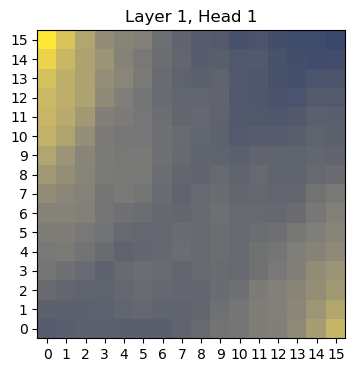

In [53]:
data_input, labels = next(iter(val_loader))
inp_data = nn.functional.one_hot(data_input, num_classes=train_loader.dataset.num_categories).float()
inp_data = inp_data.to(device)

attention_maps = model.get_attention_maps(inp_data, mask=None, start_pos=0)


attention_maps[0].shape
plot_attention_maps(data_input, attention_maps, idx=0)

In [55]:
with torch.no_grad(): 
    output = model(inp_data, mask=None, start_pos=0)
acc = (output.argmax(dim=-1).detach().cpu() == labels).float().mean()
print("Acc", acc)

Acc tensor(0.3164)
